In [1]:
import numpy as np
import pandas as pd
import random
import statistics as st
import matplotlib.pyplot as plt
import re
#First we have to get the aircraft type and decide the seats, the user can input the aircraft type 
#create a dictionary in which the key is the aircraft type and the value is capability

class flight:

    aircraft_type = {'Boeing737': 118, 'Boeing757': 170, 'Boeing767': 235,
                     'Boeing777': 321, 'Boeing787': 270, 'A350': 348}

    def __init__(self, type, capacity):
        self.type = type
        self.capacity = capacity

    @classmethod
    def get_capacity(cls):
        type = input('Aircraft type: ')

        pattern = re.compile(r'(Boeing7[35678]7)|(A350)', re.I)
        m = pattern.match(type)

        if m:
            if type[0] == 'B' or type[0] == 'b':
                type = 'Boeing' + type[-3:]
            else:
                type = 'A' + type[-3:]

            capacity = flight.aircraft_type[type]
            return cls(type, capacity)
        else:
            print('This is invalid aircraft type. Please try again.')
            return flight.get_capacity()

In [2]:
#We assumen that demand and overbooking are both binormal distribution
def get_variables(demand_hyp, demand_prob, showup_prob, overbook_num, capacity):
    demand_num = np.random.binomial(demand_hyp, demand_prob)###question demand有可能大于capacity吗？
    if demand_num <= capacity:
        sales_num = demand_num #np.random.binomial(capacity + overbook_num, demand_prob)
    else:
        sales_num = capacity + overbook_num 
    showup_num = np.random.binomial(sales_num, showup_prob)
    return sales_num, showup_num

In [3]:
def get_rev(sales_num, capacity, showup_num, profit):
    loss = []
    if showup_num <= capacity:
        revenue = profit*sales_num #assume no refund for the no_show
    else:
        for i in range(showup_num - capacity):
        #compensation according to the us federal, waiting for 1 tp 2 hours you need to compensate 
        #up to 400 dollars.....
            compensation = np.random.choice(np.array([0,400,800]), p=[0.6, 0.3, 0.1])
            single_loss = compensation
            loss.append(single_loss)
        revenue = profit*sales_num - sum(loss)
    return revenue

In [4]:
def Monte_Carlo(capacity_all, showup_prob, demand_prob, demand_hyp_bu, demand_hyp_ec):
    simu_result = {'revenue_means': [], 'plot_1': []}
    fare_class = ["business", "economics"]

    for i in range(1, 30):  # overbooking range is 1 and 30
        total_revenue_list = []
        revenue_ec, revenue_bu = [], []
        for n in range(1000):
            overbook_ec = random.randint(0, i + 1)
            overbook_bu = i - overbook_ec
            revenue_list = []
            for cs in fare_class:
                if cs == "business":
                    cost = 150  # of each seat
                    profit = cost * 0.4
                    capacity = int(capacity_all * 0.2)
                    overbook_num = overbook_bu
                    demand_hyp = demand_hyp_bu
                else:
                    cost = 100  # of each seat
                    profit = cost * 0.2
                    capacity = capacity_all - capacity
                    overbook_num = overbook_ec
                    demand_hyp = demand_hyp_ec

                sales_num = get_variables(demand_hyp, demand_prob, showup_prob, overbook_num, capacity)[0]
                showup_num = get_variables(demand_hyp, demand_prob, showup_prob, overbook_num, capacity)[1]
                revenue = get_rev(sales_num, capacity, showup_num, profit)
                revenue_list.append(revenue)

            revenue_ec.append(revenue_list[0])
            revenue_bu.append(revenue_list[1])
            total_revenue = sum(revenue_list)
            total_revenue_list.append(total_revenue)

        revenue_mean = st.mean(total_revenue_list)
        revenue_mean_ec = st.mean(revenue_ec)
        revenue_mean_bu = st.mean(revenue_bu)
        simu_result['revenue_means'].append((i, revenue_mean_bu, revenue_mean_ec, revenue_mean))
        simu_result['plot_1'].append(revenue_mean)

    return simu_result

In [5]:
def get_plot(simu_result):
    plot = plt.plot(simu_result['plot_1'])
    
    return plot

In [6]:
def get_frame(simu_result):
    frame = pd.DataFrame(data = simu_result['revenue_means'], columns = ['Overbooking Number', 'Business Revenue', 
                                                                         'Economic Revenue', 'Estimated Total Revenue'])
    
    return frame

In [7]:
def get_max_rev(frame, capacity_all):
    frame = frame.assign(**{
        'Overbooking Percentage': lambda x: x['Overbooking Number'] / capacity_all * 100
    })
    frame = frame.assign(**{
    'Overbooking Percentage': lambda x: x['Overbooking Percentage'].map('{:.2f}%'.format)
    })
    
    max_revenue = frame.loc[frame['Estimated Total Revenue'].idxmax()]
    
    return max_revenue

Aircraft type: a350


,Overbooking Number,Business Revenue,Economic Revenue,Estimated Total Revenue
0,0,5590.56,4106.70,9697.26
1,1,5599.76,4139.88,9739.64
2,2,5610.20,4167.84,9778.04
3,3,5620.90,4193.34,9814.24
4,4,5631.48,4222.50,9853.98
5,5,5640.64,4251.96,9892.60
6,6,5651.14,4282.38,9933.52
7,7,5662.00,4304.20,9966.20
8,8,5668.46,4336.96,10005.42
9,9,5678.92,4364.86,10043.78


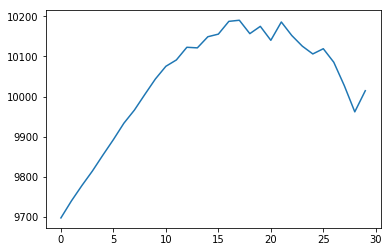

In [8]:
if __name__ == '__main__':
    # hypothesis premise
    # capacity_all = 300
    user = flight.get_capacity()
    capacity_all = user.capacity
    showup_prob = 0.85
    demand_prob = 0.9
    demand_hyp_bu = int(capacity_all * 1.2 * 0.2)  # assume largest demand is about 120% of the capacity
    demand_hyp_ec = int(capacity_all * 1.2) - demand_hyp_bu

    simu_result = Monte_Carlo(capacity_all, showup_prob, demand_prob, demand_hyp_bu, demand_hyp_ec)
    frame = get_frame(simu_result)

get_plot(simu_result)
frame

# pd.DataFrame(data = result['revenue_means'], columns = ['Overbooking Number', 'Business Revenue',
#'Economic Revenue', 'Estimated Total Revenue'])          

In [9]:
#print("overbooking percentage is %.2f" %(overbooking_percentage))   
get_max_rev(frame, capacity_all)

Overbooking Number              16
Business Revenue           5750.02
Economic Revenue           4439.72
Estimated Total Revenue    10189.7
Overbooking Percentage       4.60%
Name: 16, dtype: object